# Interaction Testing for Optimizing Neural Network Performance

Interaction testing is most often used to holistically evaluate large systems with various combinations of parameters. In some sense, a neural network can be viewed as such a system. 

## Dataset Orientation and Initial Exploration

First, let's open our dataset, which comes from Kaggle at the following link: https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction/data


In [245]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("data/Housing.csv")

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Eventually, I want to see a plot of each variable against the other to get an idea of the relationship between each variable. However, this first requires a bti of pre-processing of the data. Primarily, this involves converting yes/no responses into binary values. 

In [246]:
binary_columns = ['mainroad','guestroom','basement','hotwaterheating','airconditioning', 'prefarea']

for col in binary_columns:
    dataset[col] = dataset[col].apply(lambda x: 0 if x == 'no' else 1)

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


The only column left to convert is ```furnishingstatus```, which we'll likewise convert to a numerical value. And yes, later, we'll perform one-hot encoding.

In [247]:
furnishing_matrix = {
    "furnished":2,
    "semi-furnished":1,
    "unfurnished":0
}

dataset['furnishingstatus'] = dataset['furnishingstatus'].apply(lambda x: furnishing_matrix[x])

dataset.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


Now, to get an idea of the relationships between each variable, let's use seaborn's built-in ```pairplot``` function.

In [248]:
#import seaborn as sns

#sns.pairplot(dataset)

The most relevant to our course of inquiry is the diagonal line of histograms. Some variables are fairly evenly distributed, such as ```furnishingstatus```, while others are extremely imbalanced, such as ```hotwaterheating```.

Given the prevalence of certain variables over others, it's likely that a model trained on this data would be more accurate for data points that contain variables that show up more often, likely seeing worse performance on rarer variable occurences.

## Building a Baseline Model

Applying the same foundational principle underlying interaction testing to the housing market, it's likely that only a small subset of interactions are responsible for the cost of the house.

In [249]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [250]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

As we're trying to predict the house price, we'll first drop the ```price``` column to build our explanatory variables ```X``` and response variable ```y```.

In [251]:
# Define features and target
X = dataset.drop(columns=['price'])  # Features
y = dataset['price']  # Target variable

y_avg_unscaled = y.mean()

We then further subdivide the explanatory variables into numerical and categorical features.

In [262]:
# Separate numerical and categorical columns
numerical_features = ['area']
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                        'airconditioning', 'prefarea', 'furnishingstatus',
                        'bedrooms', 'bathrooms', 'stories']


We then use ```sklearn```'s built-in ```ColumnTransformer``` to scale the numerical and categorical variables appropiately. Using ```StandardScaler```, we scale all values between ```0``` and `1`, and use `OneHotEncoder` on categorial variables.

In [263]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale 'area'
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # One-hot encode categorical
    ]
)

# Apply preprocessing to features
X_preprocessed = preprocessor.fit_transform(X)

# Scale target variable ('price')
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

Finally, we split the data into test and train subsets.

In [264]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_scaled, test_size=0.25, random_state=42)
print(X_train.shape, y_train.shape)

(408, 20) (408,)


Next, we build and compile the model.

In [461]:

# Build the neural network
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.05), loss='mse', metrics=['mse'])

print(type(X_train), type(y_train))

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, verbose=1)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
Epoch 1/20


C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 25015357538304.0000 - mse: 25015357538304.0000 - val_loss: 20440217026560.0000 - val_mse: 20440217026560.0000
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12330151706624.0000 - mse: 12330151706624.0000 - val_loss: 3803037040640.0000 - val_mse: 3803037040640.0000
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3838705926144.0000 - mse: 3838705926144.0000 - val_loss: 3811725803520.0000 - val_mse: 3811725803520.0000
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3402291216384.0000 - mse: 3402291216384.0000 - val_loss: 3313962057728.0000 - val_mse: 3313962057728.0000
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4400949493760.0000 - mse: 4400949493760.0000 - val_loss: 3071787139072.0000 - val_mse: 3071787139072.0000
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3632642916352.0000 - mse: 3632642916352.0000 - val_loss: 3252027129856.0000 - val_mse: 3252027129856.0000
Epoch 7/20
13/13 ━━━

Finally, we train the model.

... and then evaluate it.

In [271]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)

In [272]:
# Inverse scale predictions to interpret results
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_unscaled = scaler_y.inverse_transform(model.predict(X_test).reshape(-1, 1)).ravel()

print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Train Loss (MSE): {train_loss:.4f}")
print(f"Train MAE: {train_mae:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
Test Loss (MSE): 0.5136
Test MAE: 0.5136
Train Loss (MSE): 0.1956
Train MAE: 0.1956


To determine whether our model is decent (for some definition of the word decent), we will first compare it against a dummy classifier. This classifier simply predicts the mean of the test set.

In [273]:
mean_price_baseline = y.mean()
baseline_mae = np.mean(np.abs(y_test_unscaled - mean_price_baseline))
print(f"Baseline MAE: {baseline_mae:.2f}")

Baseline MAE: 1686049.25


In [274]:
y_pred = scaler_y.inverse_transform(model.predict(X_test))
model_mae = np.mean(np.abs(y_test_unscaled - y_pred))
print(f"Model MAE: {model_mae:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model MAE: 2174538.46


Ok, so for now, we don't even beat the baseline. Future research will focus on beating this naieve baseline, but for now, we move on.

## Ensuring Input Diversity

Let's take a look at an input vector.

In [407]:
ca_dataset = dataset.copy().drop(columns=["price"])
ca_response = dataset["price"]
ca_dataset.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,1,0,0,0,1,2,1,2
1,8960,4,4,4,1,0,0,0,1,3,0,2
2,9960,3,2,2,1,0,1,0,0,2,1,1
3,7500,4,2,2,1,0,1,0,1,3,1,2
4,7420,4,1,2,1,1,1,0,1,2,0,2


Let's modify the area column using `pd.qcut`.

In [366]:
n_splits = 3
ca_dataset["area"] = pd.qcut(ca_dataset["area"], q=n_splits, labels=list(range(n_splits)))
ca_dataset

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,2,4,2,3,1,0,0,0,1,2,1,2
1,2,4,4,4,1,0,0,0,1,3,0,2
2,2,3,2,2,1,0,1,0,0,2,1,1
3,2,4,2,2,1,0,1,0,1,3,1,2
4,2,4,1,2,1,1,1,0,1,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
540,0,2,1,1,1,0,1,0,0,2,0,0
541,0,3,1,1,0,0,0,0,0,0,0,1
542,0,2,1,1,1,0,0,0,0,0,0,0
543,0,3,1,1,0,0,0,0,0,0,0,2


Therefore, our input dataset can be represented as a mixed-level covering array whose values have the following properties:

In [367]:
mlca_values = ca_dataset.nunique().tolist()
ca_dataset.nunique()

area                3
bedrooms            6
bathrooms           4
stories             4
mainroad            2
guestroom           2
basement            2
hotwaterheating     2
airconditioning     2
parking             4
prefarea            2
furnishingstatus    3
dtype: int64

Now, we need to create a covering array using the rows of our input dataset.

In [368]:
candidate_rows = ca_dataset.values.tolist()

In [ ]:
import itertools
import math

def is_a_covering_array(A, mlca_values, t):
    k = len(A[0])

    for col_combo in itertools.combinations(range(k), t):
        # Create a set to store unique t-tuples of values
        unique_tuples = set()
        for row in A:
            tuple_values = tuple(row[i] for i in col_combo)
            unique_tuples.add(tuple_values)

        num_combos = math.prod([mlca_values[col] for col in col_combo])
        
        if len(unique_tuples) < num_combos:
            return False
    return True

In [375]:
is_a_covering_array(candidate_rows, mlca_values, 2)

False

Well, it turns out our original dataset isn't even covering. Let's remove some less-common values to make it so.

In [376]:
candidate_rows = ca_dataset.values.tolist()
mlca_values = ca_dataset.nunique().tolist()
ca_dataset.nunique()

area                3
bedrooms            6
bathrooms           4
stories             4
mainroad            2
guestroom           2
basement            2
hotwaterheating     2
airconditioning     2
parking             4
prefarea            2
furnishingstatus    3
dtype: int64

In [377]:
is_a_covering_array(candidate_rows, mlca_values, 2)

False

Ok, this isn't particularily helpful. I've tried ripping values and filtering values, but without grotesquely destroying the input data, there's no chance of creating a covering array. The best I can do is percent coverage, which still ensures input diversity.

In [378]:
def percent_covering(A, mlca_values, t):
    k = len(A[0])

    num_covered_interactions = 0
    total_covered_interactions = 0

    for col_combo in itertools.combinations(range(k), t):
        # Create a set to store unique t-tuples of values
        unique_tuples = set()
        for row in A:
            tuple_values = tuple(row[i] for i in col_combo)
            unique_tuples.add(tuple_values)

        num_combos = math.prod([mlca_values[col] for col in col_combo])

        num_covered_interactions += len(unique_tuples)
        total_covered_interactions += num_combos

    return num_covered_interactions / total_covered_interactions

In [393]:
percent_covering(candidate_rows, mlca_values, 3)

0.7205001761183515

Ok, not bad. The baseline is 72% covering with `t=3`. Let's set a threshold and see how few rows we need to ensure it's covering. And since we can't really modify values within a row, the best we can do is randomly select rows. But again, let's first split into train and test: 

In [474]:
import random

n_iter = 1000
trial_percent = []
t = 3
n_rows = 200

for i in range(n_iter):
    subset = random.sample(candidate_rows, k=n_rows)
    pc = percent_covering(subset, mlca_values, t)
    trial_percent.append(pc)

print(f"Best coverage: {max(trial_percent):.2%}")
print(f"Worst coverage: {min(trial_percent):.2%}")
print(f"Avg coverage: {sum(trial_percent)/len(trial_percent):.2%}")

Best coverage: 61.02%
Worst coverage: 51.46%
Avg coverage: 56.40%


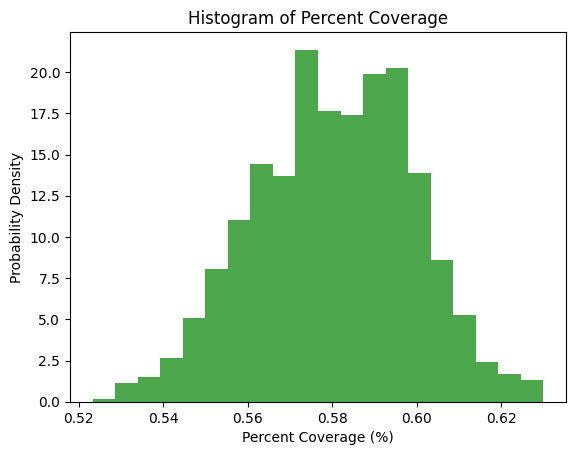

In [404]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(trial_percent, bins=20, density=True, alpha=0.7, color='g')

# Customize the plot
plt.xlabel('Percent Coverage (%)')
plt.ylabel('Probability Density')
plt.title('Histogram of Percent Coverage')

# Show the plot
plt.show()

Exploration into the number of rows is a potential avenue forward. However, as for now, we'll limit it to 150. Most percent coverage variation stays within an 8% spread.

Now, for each subset, we'll fit a model to it, and we'll be able to plot its `mse` against its percent coverage.

In [475]:
from tqdm import tqdm

n_iter = 200
n_rows = 200
t = 3

results = {}

X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=["price"]), dataset["price"], test_size=0.25)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test_processed = pd.DataFrame(preprocessor.transform(X_test).toarray())
y_test_processed = pd.Series(scaler_y.transform(y_test.values.reshape(-1, 1)).ravel())

n_splits = 4
ca_train = X_train.copy()
ca_train["area"] = pd.qcut(ca_train["area"], q=n_splits, labels=list(range(n_splits)))

mlca_values = ca_train.nunique().tolist()

ca_train = ca_train.values.tolist()

tf.get_logger().setLevel('ERROR')

for trial in range(n_iter):
    # take a n=150 subset of the train dataset
    X_train_subset = X_train.sample(n=min(150, len(X_train)))
    y_train_subset = y_train.loc[X_train_subset.index]
    
    ca_subset = [ca_train[i] for i in X_train_subset.index.tolist()]

    # calculate the percent coverage of the X_train_subset
    pc = percent_covering(ca_subset, mlca_values, t)

    X_train_subset_processed = pd.DataFrame(preprocessor.transform(X_train_subset).toarray())
    y_train_subset_processed = pd.Series(scaler_y.transform(y_train_subset.values.reshape(-1, 1)).ravel())

    # Build the neural network
    model = Sequential([
        Dense(32, activation='relu', input_dim=X_train_subset_processed.shape[1]),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear activation for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.05), loss='mse', metrics=['mse'])

    # Train the model
    history = model.fit(X_train_subset_processed, y_train_subset_processed, validation_data=(X_test_processed, y_test_processed), 
                        epochs=50, batch_size=32, verbose=0)
    
    loss, mse = model.evaluate(X_test_processed, y_test_processed, verbose=0) 

    results[trial] = {"percent_coverage": pc,
                      "loss":loss,
                      "mse":mse}


C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\matthew.wanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\P

 
-0.008475 x + 0.5223


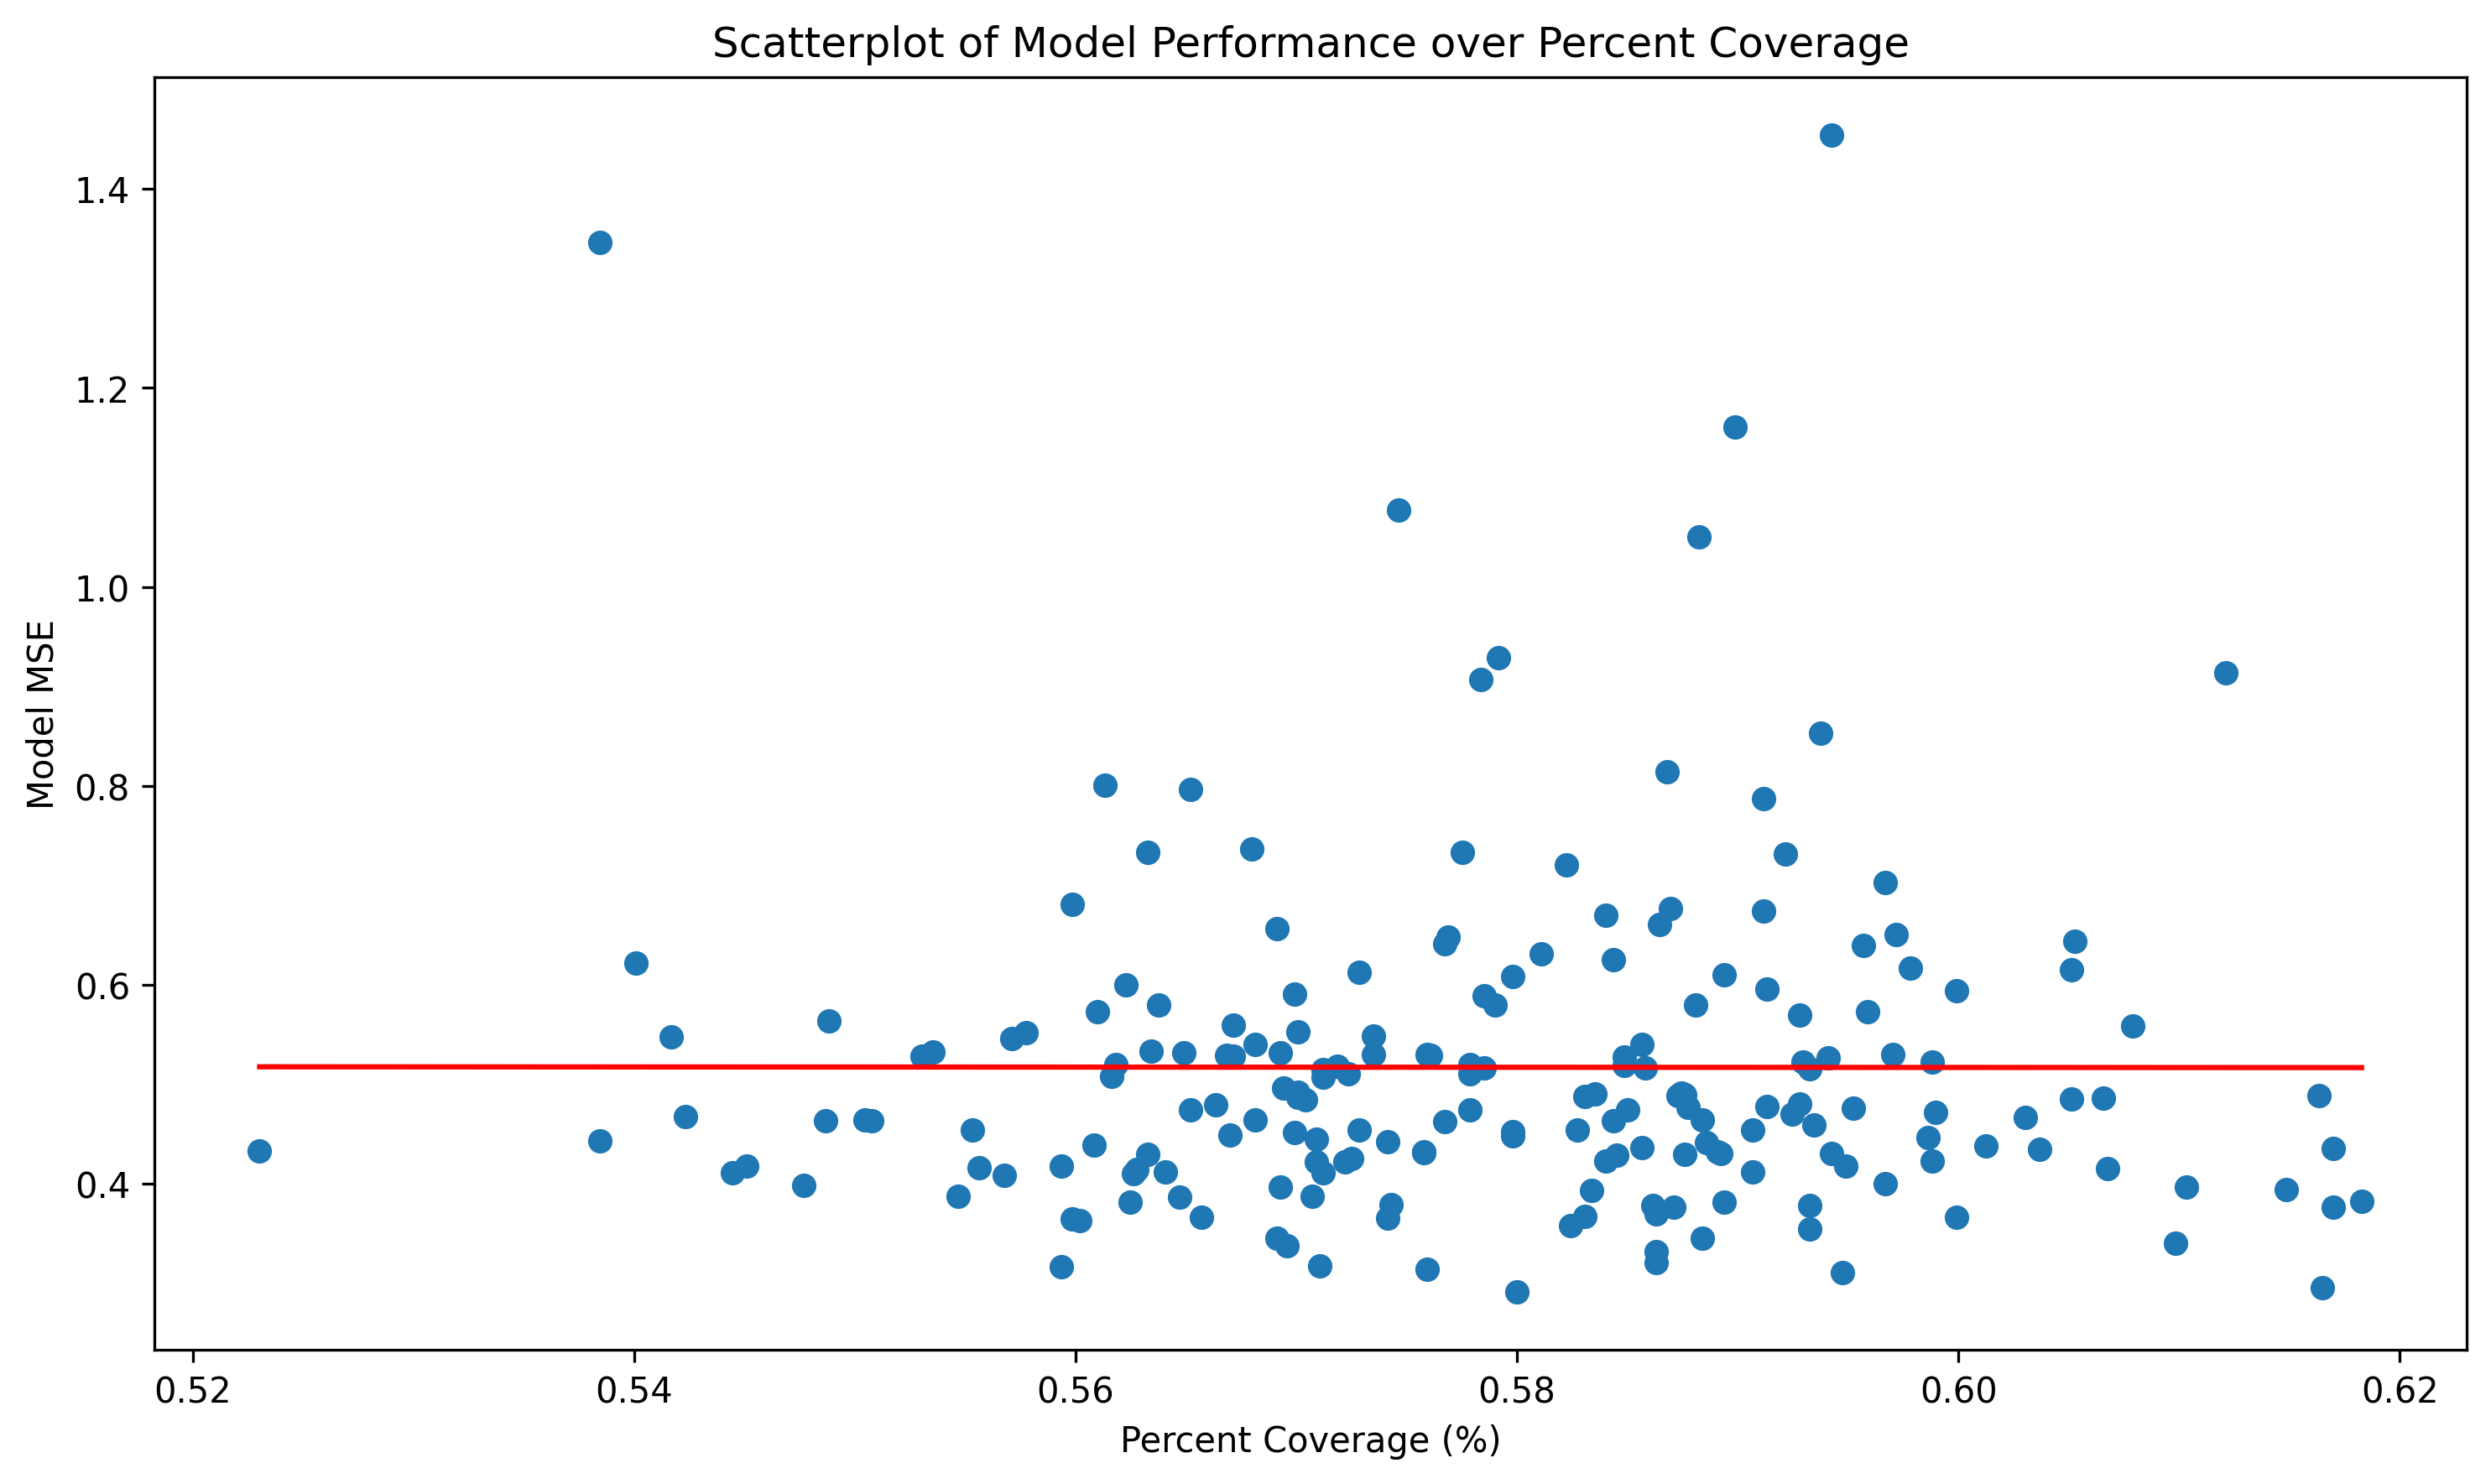

<Figure size 640x480 with 0 Axes>

In [483]:
# Create a plot
x = [r["percent_coverage"] for r in results.values()]
y = [r["mse"] for r in results.values()]

# Calculate the coefficients of the best-fit line
coefficients = np.polyfit(x, y, 1)  # 1 for linear fit
polynomial = np.poly1d(coefficients) # Create the polynomial function
print(polynomial)

# Generate x-values for the line of best fit
x_line = np.linspace(min(x), max(x), 100)

# Calculate y-values for the line of best fit
y_line = polynomial(x_line)


plt.figure(figsize=(10, 6), dpi=300)

plt.scatter(x, y)
plt.plot(x_line, y_line, color='red')

# Customize the plot
plt.xlabel('Percent Coverage (%)')
plt.ylabel('Model MSE')
plt.title('Scatterplot of Model Performance over Percent Coverage')
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("scatter_1.png")

In [477]:
import json

with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)